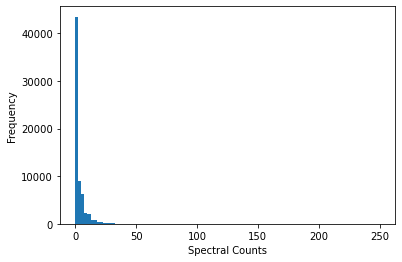

In [1]:
import graph_tool as gt

from graph_tool.all import graph_draw

import inspect
from itertools import combinations
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path, PosixPath

import pandas as pd
import scipy
#User
import pynetio as mio
from myitertools import exhaust, forp
import predicates as pred
from utils import doc, ls, psrc



home = Path.home()

if Path(".").absolute() == PosixPath('/home/aji/Projects/dev/pynet/pyext'):
    src = Path(".")
else:
    src = home / 'Projects/dev/pynet'
data = src / 'data'
lip = data / 'sars-cov-2-LiP'
multi = data / 'multi-proteomics'
apms_stuk = multi / '41586_2021_3493_MOESM6_ESM.xlsx'
apms_stuk_sheetname = 'A - Significant interactions'
apms_gordon = data / 'sars-cov-2-ppi/41586_2020_2286_MOESM5_ESM.xlsx'

#Variables for testing lip funcitons

xls_paths = list(mio.gen_excelpaths_from_dir(lip))
lip1 = xls_paths[1]

lipgen = mio.parse_lip_xls_file(lip1)

apms = pd.read_excel(apms_gordon)

def spec_counts_str_col_to_array(sc):
    def sc_row_to_list(scrow):
        mylist = []
        for i in scrow.split('|'):
            mylist.append(int(i))
        return mylist
    row_list = []
    for row in sc:
        row_list.append(sc_row_to_list(row))
    return np.array(row_list, dtype=np.uint8)
apms[['scr1', 'scr2', 'scr3']]=spec_counts_str_col_to_array(apms['Spec'])
    


#The histogram of spectral counts
plt.hist(np.ravel(list(apms[i].values for i in ['scr1', 'scr2', 'scr3'])), bins=100)
plt.xlabel('Spectral Counts')
plt.ylabel("Frequency")
plt.show()

In [2]:
"""
gid indexes into the sequence of ordered undirected graphs
mantissa indexes into the sequence of ordered subgraphs
with ne edges
"""

def femax(vmax):
    """
    Returns the maximum number of edges in the undirected graph
    """
    return vmax*(vmax - 1) // 2
def edge_combs(emax):
    """
    Returns an edge combination generator
    The value is the number of combinations
    The index is the number of edges
    
    e.g., index 0 1 2 3
          value 1 3 3 1
    """
    return (int(scipy.special.comb(emax, i)) for i in range(emax+1))
            
def ne(gid, vmax):
    """
    Returns the number of edges for a given gid & vmax
    """
    emax = femax(vmax)
    
    #The index of combs is the edge number
    combs = list(edge_combs(emax))
    assert sum(combs) == 2**emax
    
    solutions = 0
    edges = 0
    while gid >= solutions:
        solutions += combs[edges]
        edges +=1
    return edges - 1

def base(nedges, vmax):
    """
    returns the base for nedges and vmax
    The graph id (gid) = base + mantissa
    """
    emax = femax(vmax)
    combs = list(edge_combs(emax))
    return sum(combs[0:nedges])

def mantissa(gid, vmax):
    """
    returns the mantissa for gid, vmax
    gid = base + mantissa
    """
    b = base(ne(gid, vmax), vmax)
    return gid - b

def next_vertex(i):
    """
    Count the next vertex, undefined over vmax
    """
    return i + 1

def prev_vertex(i):
    """
    Count the previous vertex, undefined for i < 1
    """
    return i - 1

def next_edge(e, vertex_n_max):
    """
    Return the next edge in the sequence
    """
    if e[1] < vertex_n_max - 1: return (e[0], e[1]+1)
    else: return (e[0] + 1, e[0] + 2)
    
def prev_edge(e, vmax):
    """
    Count the previous edge in the sequence
    """
    #if e > first_e:
    # (0, 2) -> (0, 1)
    if e[1] > e[0] + 1: return (e[0], e[1] - 1)
    # (1, 2) -> (0, 3)
    else: return (e[0] - 1, vmax - 1)

def generate_eseq(estart, vertex_n_max):
    yield estart
    while estart != (vertex_n_max - 2, vertex_n_max - 1):
        next_e = next_edge(estart, vertex_n_max)
        estart = next_e
        yield estart   

def permutations(nitems):
    perms = []
    for i in range(nitems):
        for j in range(i+1, nitems):
            perms.append((i, j))
    return perms


def generate_graph(gid, vmax):
    """
    Return an ordered elist from a graph id and n vertices
    """
    nedges = ne(gid, vmax)
    b = base(nedges, vmax)
    m = mantissa(gid, vmax)
    
    if gid == 0:
        return []
    else:
        all_edges = list(generate_eseq((0, 1), vmax))
        combinations_iter = combinations(range(len(all_edges)), nedges)
        
        for i, combo in enumerate(combinations_iter):
            #print(i, combo)
            if i == m:
                eseq = []
                #print(combo)
                for idx in combo:
                    eseq.append(all_edges[idx])
                return eseq
            
def test_next_prev(vmax):
    print("fEdges for vmax = {vmax}")
    print(' e      next   prev   pne    npe   b')
    for e in generate_eseq((0, 1), vmax):
        ne = next_edge(e, vmax)
        pe = prev_edge(e, vmax)
        pne = prev_edge(ne, vmax)
        npe = next_edge(pe, vmax)
        b = e == npe
        
        print(e, ne, pe, pne, npe, b)
    

vmax = 9
emax = femax(vmax)
solutions = 2**emax
print('solutions {:.1E}'.format(solutions))
print('gid >= base')
print('gid = base + mantissa')
y = list(edge_combs(emax))
print(y)
print('gid ne base mantissa  graph')

if solutions <= 256:
    for i in range(2**emax):
        nedges = ne(i, vmax)
        g = generate_graph(i, vmax)
        print(f'{i}   {ne(i, vmax)}   {base(nedges, vmax)}\t{mantissa(i, vmax)}  {g}')

solutions 6.9E+10
gid >= base
gid = base + mantissa
[1, 36, 630, 7140, 58905, 376992, 1947792, 8347680, 30260340, 94143280, 254186856, 600805296, 1251677700, 2310789600, 3796297200, 5567902560, 7307872110, 8597496599, 9075135300, 8597496599, 7307872110, 5567902560, 3796297200, 2310789600, 1251677700, 600805296, 254186856, 94143280, 30260340, 8347680, 1947792, 376992, 58905, 7140, 630, 36, 1]
gid ne base mantissa  graph


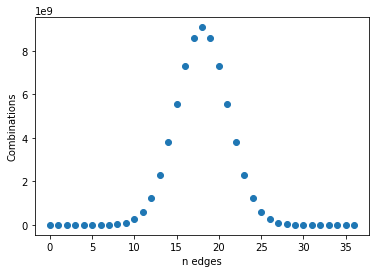

In [3]:
plt.scatter(range(len(y)), y)
plt.xlabel('n edges')
plt.ylabel('Combinations')
plt.show()

In [5]:
t1 = [(0, 1)]
t2 = [(0, 2)]
t3 = [(1, 2)]
t4 = [(0, 1), (0, 2)]
t5 = [(0, 1), (1, 2)]
t6 = [(0, 1), (0, 2), (1, 2)]

#
t3_4 = [(0, 3)]


master = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


tests = {3:[t1, t2, t3, t4, t5, t6],
         4:[[(0, 1)], #4 1 6 1 : 1 : master[gid-1]
            [(0, 2)], #4 1 6 2 : 2
            [(0, 3)], #4 1 6 3 : 3
            [(1, 2)], #4 1 6 4 : 4
            [(1, 3)], #4 1 6 5 : 5
            [(2, 3)], #4 1 6 6 : 6
            [(0, 1), (0, 2)], #4 2 5 1 : 7 master[0:gid] = master[]
            [(0, 1), (0, 3)], #4 2 5 2 : 8
            [(0, 1), (1, 2)], #4 2 5 3 : 9
            [(0, 1), (1, 3)], #4 2 5 4 : 10
            [(0, 1), (2, 3)], #4 2 5 5 : 11
            [(0, 2), (0, 3)], #4 2 4 1 : 12 master[1:gid]
            [(0, 2), (1, 2)], #
            [(0, 2), (1, 3)],
            [(0, 2), (2, 3)],
            [(0, 3), (1, 2)],
            [(0, 3), (1, 3)],
            [(0, 3), (2, 3)],
            [(1, 2), (1, 3)],
            [(1, 2), (2, 3)],
            [(1, 3), (2, 3)],
            [(0, 1), (0, 2), (0, 3)],
            [(0, 1), (0, 2), (1, 2)],
            [(0, 1), (0, 2), (1, 3)],
            [(0, 1), (0, 2), (2, 3)],
            [(0, 1), (0, 3), (1, 2)],
            [(0, 1), (0, 3), (1, 3)],
            [(0, 1), (0, 3), (2, 3)]
            [(0, 1), (0, 2), (0, 3), (1, 2)]
           ]}


# 4 choose 2
# 1, 2 | 1, 3 | 1

for key, item in tests.items():
    print('\n')
    for i, test in enumerate(item):
        result = next_n_graph(test, key)
        try:
            compare = result == item[i+1]
        except IndexError:
            compare = "IndexError"
        print(f'key:{key} test:{test} return: {result} compare: {compare}')

<>:43: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
<>:43: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
/tmp/ipykernel_134591/516857291.py:43: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  [(0, 1), (0, 3), (2, 3)]


TypeError: list indices must be integers or slices, not tuple

In [47]:
# (0, 1) ne
# (0, 2) ne
# (1, 2)

# (0, 1), (0, 2) ne
# (0, 1), (1, 2) ne
# (0, 2), (1, 2)

# (0, 1), (0, 2), (1, 2)


# (0, 1)
# (0, 2)
# (0, 3)
# (1, 2)
# (1, 3)
# (2, 3)

# (0, 1), (0, 2)
# (0, 1), (0, 3)
# (0, 1), (1, 2)
# (0, 1), (1, 3)
# (0, 1), (2, 3)

# (0, 2), (0, 3)
# (0, 2), (1, 2) ...


# (0, 1), (0, 2), (0, 3)
# (0, 1), (0, 2), (1, 2)
# (0, 1), (0, 2), (1, 3)
# (0, 1), (0, 2), (2, 3)

# (0, 1), (0, 3), (1, 2)
# (0, 1), (0, 3), (1, 3)
# (0, 1), (0, 3), (2, 3)

# (0, 1), (1, 2), (1, 3)
# (0, 1), (1, 2), (2, 3)
# (0, 1), (1, 3), (2, 3)

# (0, 1), (2,3), (3, 4) #reject


In [93]:
#Introduce Integrative Network Modeling
#Motivate the problem, emphasis on generalizability

#Illustration with APMS data likelihood and prior

#Prior based on graph density -> Benchmark on Corum

#Likelihood based on the covariation of abundances in APMS data

#Comparison to know complexes in Corum

#Prior predictive check

#Next steps

[1, 2]